# FEATURE ENGINEERING AND PREPROCESSING

In the following part:
1. Since some data have heavily right-skewed distributions, we do log1p transformations
2. Text structure feature extraction (based on title) to get Comprehensive emotional score/Is it a clickbait/Have a number or not/ Have a punctuation or not.
3. Temporal feature extraction. Get whether it's a business day or not, whether it's a holiday or not
4. Engagement Ratios: like_view_ratio and comment_view_ratio

In [22]:
import pandas as pd

df = pd.read_csv("cleaned_data.csv")

df.head()

,video_id,title,description,published_at,channel_id,channel_title,tags,view_count,like_count,comment_count,...,publish_day,publish_hour,publish_month,tag_count,description_clean,tags_clean,text,cluster,tsne_x,tsne_y
0,ih88GVHyDZY,Who suffers in Cape Town’s water crisis? | Fea...,"After three years of poor rainfall, in 2018, C...",2025-04-16 14:30:26+00:00,UCNye-wNBqNL5ZzHSJj3l8Bg,Al Jazeera English,"['Climate Crisis', 'Environment', 'Human Right...",15098,242,44,...,Wednesday,14,4,27,"After three years of poor rainfall, in 2018, C...",Climate Crisis Environment Human Rights Water ...,Who suffers in Cape Town’s water crisis? | Fea...,3,39.532080,-10.890060
1,WgdPLrDYb6I,10 Lines on Global Warming in English | Global...,10 Lines on Global Warming in English | Global...,2025-02-18 14:15:06+00:00,UCkyD9FJb4jCbPiOks_pZnFw,Let's Write,"['Global Warming for students', 'Causes of Glo...",2584,25,3,...,Tuesday,14,2,17,10 Lines on Global Warming in English | Global...,Global Warming for students Causes of Global W...,10 Lines on Global Warming in English | Global...,2,-41.358864,-12.274280
2,Yurzj5gSg98,Sasha Alex Sloan - Global Warming (Lyric Video),I Blame The World // The New Album Out Now\nLi...,2022-05-13 04:00:10+00:00,UCMbVhQmWVSYX-o5y29XSCXg,SashaSloanVEVO,"['Global Warming', 'Pop', 'RCA Records Label',...",192885,3653,63,...,Friday,4,5,4,I Blame The World // The New Album Out Now Lis...,Global Warming Pop RCA Records Label Sasha Ale...,Sasha Alex Sloan - Global Warming (Lyric Video...,2,-24.655966,21.791931
3,xivQ8zjqaRo,UN Sustainable Development Goals | Climate Act...,"Hello there! In this video, we talk about of t...",2017-11-02 02:42:53+00:00,UCn-2Vq_5GdUr1ZVnCKg7xjQ,EarthAgain,[],48346,390,20,...,Thursday,2,11,0,"Hello there! In this video, we talk about of t...",NaN,UN Sustainable Development Goals | Climate Act...,4,4.747887,-33.022310
4,FlY5dj6kLl0,The Climate Action Simulation Game,The Climate Action Simulation is a highly inte...,2021-02-12 17:44:51+00:00,UCqIrcmlomSKTJxYC2d0bOKw,Climate Interactive,[],10195,33,0,...,Friday,17,2,0,The Climate Action Simulation is a highly inte...,NaN,The Climate Action Simulation Game,1,4.399699,-18.340784


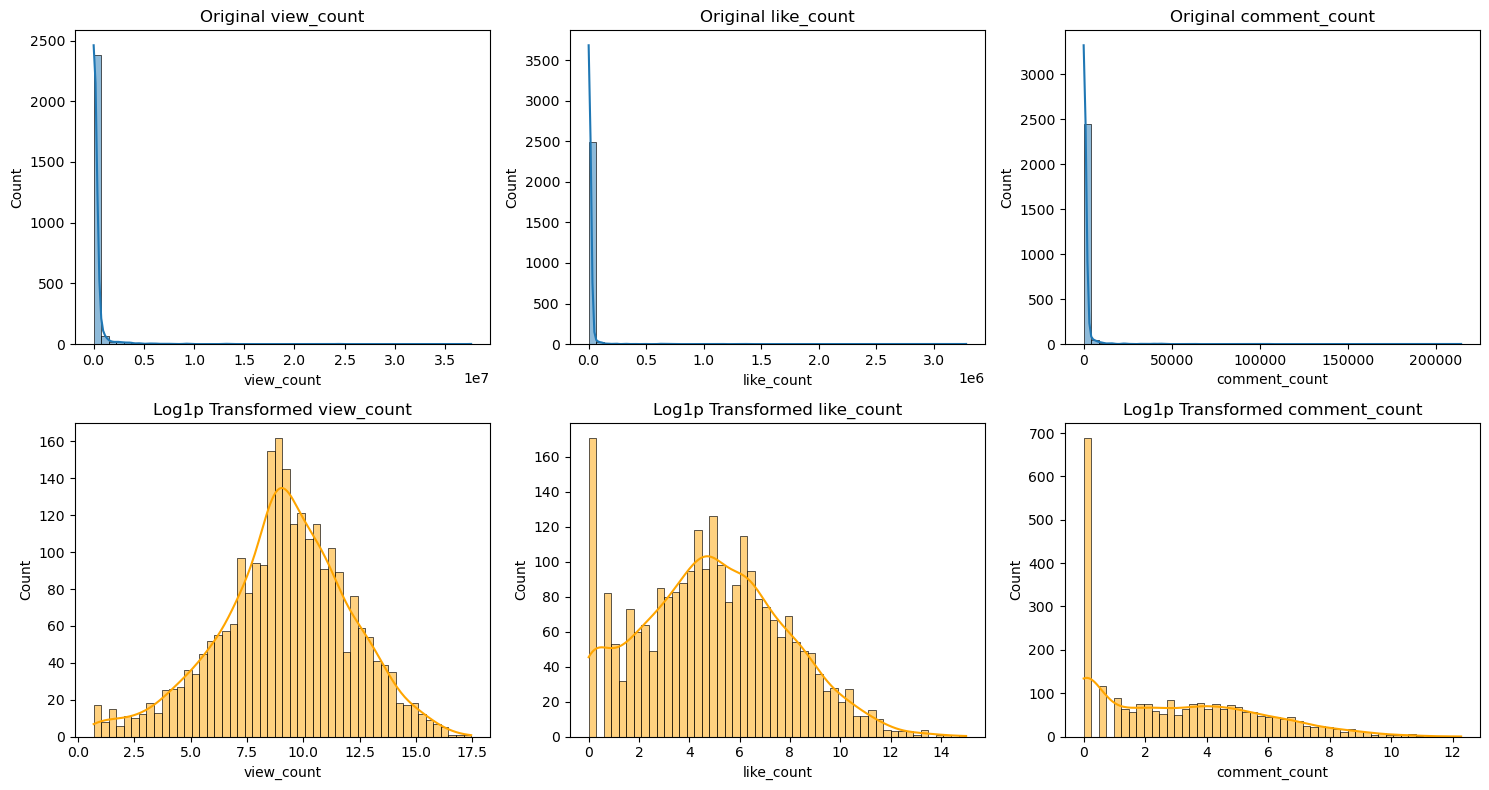

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Applying log1p transformations
df_log = df.copy()
df_log["view_count"] = np.log1p(df_log["view_count"])
df_log["like_count"] = np.log1p(df_log["like_count"])
df_log["comment_count"] = np.log1p(df_log["comment_count"])

# Visual comparison before and after the change
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(['view_count', 'like_count', 'comment_count']):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Original {col}')
    sns.histplot(df_log[col], bins=50, kde=True, ax=axes[1, i], color='orange')
    axes[1, i].set_title(f'Log1p Transformed {col}')

plt.tight_layout()
plt.show()

df["view_count"] = np.log1p(df["view_count"])
df["like_count"] = np.log1p(df["like_count"])
df["comment_count"] = np.log1p(df["comment_count"])

In [3]:
# !pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

analyzer = SentimentIntensityAnalyzer()

# Text feature construction: sentiment score, eye-catching or not, contains numbers/punctuation or not
def extract_text_features(row):
    title = row['title'] if pd.notnull(row['title']) else ''
    sentiment = analyzer.polarity_scores(title)['compound'] # from [-1,1]
    # Recognize "eye-catching" headlines, which always be'top','u won't believe','top'
    is_clickbait = int(bool(re.search(r'\b(top|best|worst|amazing|shocking|you won’t believe|incredible)\b', title.lower())))
    has_number = int(bool(re.search(r'\d+', title)))
    has_punctuation = int(bool(re.search(r'[!?.]', title)))
    return pd.Series([sentiment, is_clickbait, has_number, has_punctuation])

In [25]:
df[['title_sentiment', 'is_clickbait', 'has_number', 'has_punctuation']] = df.apply(extract_text_features, axis=1)

In [26]:
df[['title', 'title_sentiment', 'is_clickbait', 'has_number', 'has_punctuation']].head()

,title,title_sentiment,is_clickbait,has_number,has_punctuation
0,Who suffers in Cape Town’s water crisis? | Fea...,-0.8020,0.0,0.0,1.0
1,10 Lines on Global Warming in English | Global...,0.2960,0.0,1.0,0.0
2,Sasha Alex Sloan - Global Warming (Lyric Video),0.1531,0.0,0.0,0.0
3,UN Sustainable Development Goals | Climate Act...,0.0000,0.0,1.0,0.0
4,The Climate Action Simulation Game,0.0000,0.0,0.0,0.0


In [27]:
#Whether it is a weekday (1 for Monday through Friday, 0 for weekends)
df['published_at'] = pd.to_datetime(df['published_at'])
df['publish_weekday'] = df['published_at'].dt.weekday
df['is_weekday'] = df['publish_weekday'].apply(lambda x: 1 if x < 5 else 0)

from pandas.tseries.holiday import USFederalHolidayCalendar

us_calendar = USFederalHolidayCalendar()
holidays = us_calendar.holidays(start=df['published_at'].min(), end=df['published_at'].max())

df['is_holiday'] = df['published_at'].dt.normalize().isin(holidays).astype(int)

df[['published_at', 'is_weekday', 'is_holiday']].head(10)

,published_at,is_weekday,is_holiday
0,2025-04-16 14:30:26+00:00,1,0
1,2025-02-18 14:15:06+00:00,1,0
2,2022-05-13 04:00:10+00:00,1,0
3,2017-11-02 02:42:53+00:00,1,0
4,2021-02-12 17:44:51+00:00,1,0
5,2021-11-12 20:49:34+00:00,1,0
6,2022-05-24 12:51:30+00:00,1,0
7,2022-11-03 10:00:19+00:00,1,0
8,2025-04-16 07:18:14+00:00,1,0
9,2020-01-21 09:26:37+00:00,1,0


In [28]:
import numpy as np

# Constructing engagement ratio characteristics: likes/views, comments/views
df['like_view_ratio'] = np.where(df['view_count'] > 0, df['like_count'] / df['view_count'], 0)
df['comment_view_ratio'] = np.where(df['view_count'] > 0, df['comment_count'] / df['view_count'], 0)
df[['view_count', 'like_count', 'comment_count', 'like_view_ratio', 'comment_view_ratio']].head(10)

,view_count,like_count,comment_count,like_view_ratio,comment_view_ratio
0,9.622384,5.493061,3.806662,0.570863,0.395605
1,7.857481,3.258097,1.386294,0.414649,0.176430
2,12.169855,8.203578,4.158883,0.674090,0.341736
3,10.786159,5.968708,3.044522,0.553367,0.282262
4,9.229751,3.526361,0.000000,0.382065,0.000000
5,8.025516,2.302585,0.000000,0.286908,0.000000
6,7.708411,3.091042,0.000000,0.400996,0.000000
7,8.412499,4.488636,2.197225,0.533568,0.261186
8,10.481224,0.000000,3.583519,0.000000,0.341899
9,6.903747,3.806662,3.610918,0.551391,0.523037


In [29]:
df.to_csv('cleaned_FE_data.csv', index=False)

# MODEL

This section simply uses the numerical results as input features and like_view_ratio as the regression target. 

We applied RandomForest, XGBoost, and LinearRegressionion

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("cleaned_FE_data.csv")


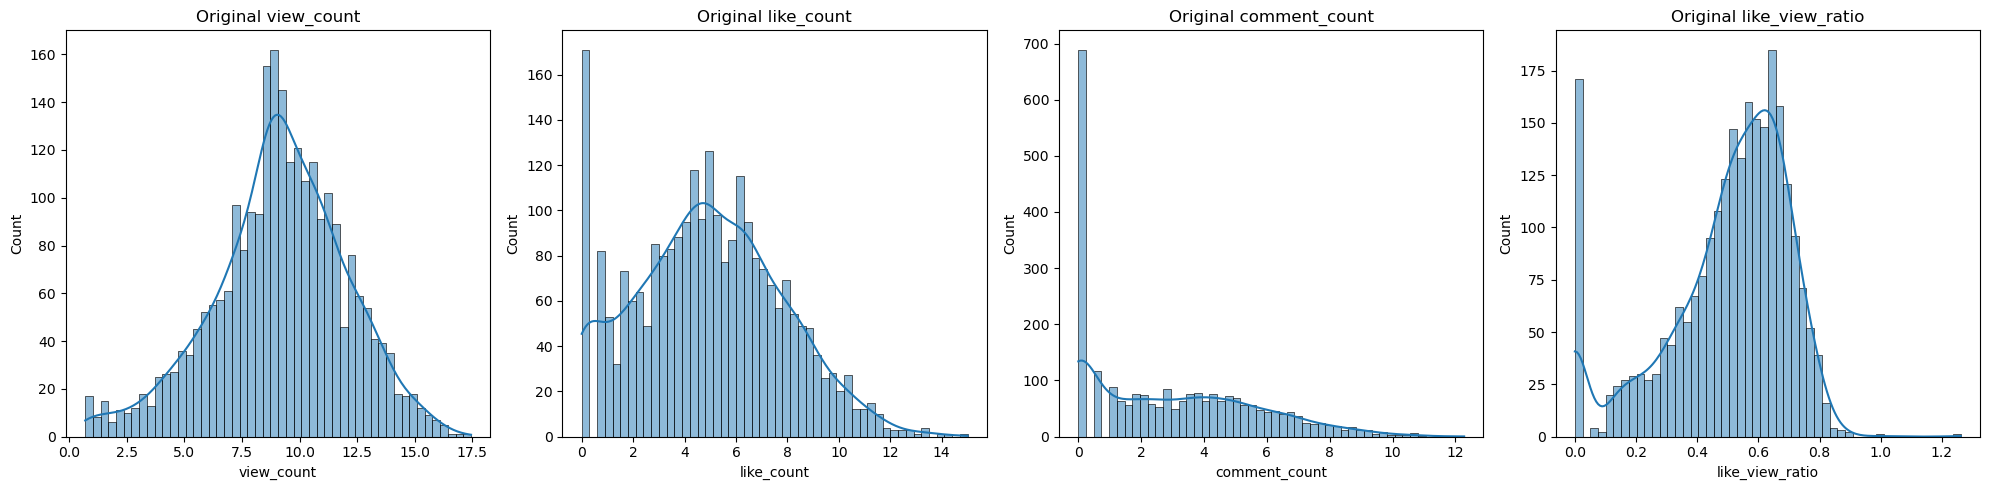

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(['view_count', 'like_count', 'comment_count', 'like_view_ratio']):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Original {col}')

plt.tight_layout()
plt.show()

In [31]:
target = 'like_view_ratio

features = [
    'title_sentiment', 'is_clickbait', 'has_number', 'has_punctuation',
    'publish_hour', 'publish_weekday', 'is_weekday', 'publish_month', 'is_holiday'
]

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# Standardization and segmentation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'R2': r2_score(y_test, preds)
    }

results_df = pd.DataFrame(results).T
results_df

,MAE,RMSE,R2
RandomForest,0.165146,0.214107,-0.106745
XGBoost,0.174626,0.225323,-0.225736
LinearRegression,0.157677,0.202893,0.006153


Since we didn't analyze and put text data in the model, we can find that the results are bad.

Later, we will add text data into the model.